<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Baseline_U_Mixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD" -O CheXpert-v1.0-small.zip && rm -rf /tmp/cookies.txt

In [0]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [0]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [0]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [0]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [0]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [0]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [0]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=59).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-02


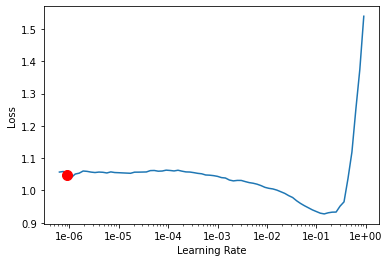

In [11]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 4e-2

In [0]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric')])

epoch,train_loss,valid_loss,avg_auc_metric,time


In [0]:
validation_eval(learn)